# SARIMAX Modeling
*by Alyssia Oh*

In [2]:
# import libraries
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import warnings

In [4]:
# import datasets
cases_df = pd.read_csv('../clean_data/Cases_Normalized_per_100k.csv')
cases_df.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
0,Alameda,29.0,0.0,29,0,2020-03-18,0.019,0.008,0.055,0.123,0.795,1671329,1.735146,1.735146,0.000000,0.000000,NaN,NaN,NaN,NaN
1,Alameda,36.0,0.0,7,0,2020-03-19,0.019,0.008,0.055,0.123,0.795,1671329,2.153974,0.418828,0.000000,0.000000,NaN,NaN,NaN,NaN
2,Alameda,42.0,0.0,6,0,2020-03-20,0.019,0.008,0.055,0.123,0.795,1671329,2.512970,0.358996,0.000000,0.000000,NaN,NaN,NaN,NaN
3,Alameda,62.0,0.0,20,0,2020-03-21,0.019,0.008,0.055,0.123,0.795,1671329,3.709623,1.196652,0.000000,0.000000,NaN,NaN,NaN,NaN
4,Alameda,72.0,1.0,10,1,2020-03-22,0.019,0.008,0.055,0.123,0.795,1671329,4.307949,0.598326,0.059833,0.059833,NaN,NaN,NaN,NaN


In [4]:
cases_df.describe()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,population,confirmedper100k,newlyconfirmedper100k,deathper100k,newdeath100k,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,7dayrollingavg_newlyconfirmed_rawnumber,7dayrollingavg_newdeath_rawnumber
count,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,17776.000000,1.777600e+04,17776.000000,17776.000000
mean,1.327444e+04,210.774443,173.013187,2.048003,0.032279,0.030699,0.063650,0.158545,0.714792,6.823606e+05,1542.530785,20.284986,19.606417,0.210988,20.232502,2.081917e-01,172.290086,2.001583
std,5.201773e+04,852.430551,814.985729,11.017366,0.028533,0.026178,0.033898,0.040410,0.092762,1.456208e+06,2084.332897,43.944282,28.624650,0.831238,31.417552,4.040341e-01,775.800926,9.438015
min,0.000000e+00,0.000000,-1157.000000,-16.000000,0.001000,0.000000,0.004000,0.058000,0.482000,1.129000e+03,0.000000,-74.546183,0.000000,-5.543545,-6.977150,-7.919349e-01,-1.142857,-1.428571
25%,9.400000e+01,1.000000,1.000000,0.000000,0.015000,0.013000,0.040000,0.134000,0.661000,4.590500e+04,99.646385,0.606875,1.002456,0.000000,2.049615,1.522592e-15,2.000000,0.000000
50%,1.044000e+03,15.000000,14.000000,0.000000,0.023000,0.023000,0.058000,0.156000,0.737000,1.928430e+05,711.532789,6.700781,8.138623,0.000000,8.310360,5.983262e-02,18.285714,0.142857
75%,8.147250e+03,114.000000,85.000000,0.000000,0.043000,0.043000,0.084000,0.186000,0.786000,7.621480e+05,2248.121154,22.165620,27.829294,0.000000,24.251025,2.301092e-01,89.464286,1.000000
max,1.048757e+06,15260.000000,28549.000000,318.000000,0.140000,0.135000,0.162000,0.276000,0.889000,1.003911e+07,15791.711641,1860.053144,272.052534,27.717723,566.793296,6.335479e+00,15711.142857,241.285714


In [5]:
# convert date to datetime
cases_df['date'] = pd.to_datetime(cases_df['date'])

In [6]:
# drop no longer needed columns
cases_df.drop(['totalcountconfirmed', 'totalcountdeaths', 'newcountconfirmed',
              'newcountdeaths', 'NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 
              'ALWAYS', 'deathper100k', 'newdeath100k', 'confirmedper100k', 'population',
               'newlyconfirmedper100k' ,'7dayrollingavg_newlyconfirmed_rawnumber', '7dayrollingavg_newdeath_rawnumber'], 
             axis = 1, inplace = True)
cases_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath
0,Alameda,2020-03-18,NaN,NaN
1,Alameda,2020-03-19,NaN,NaN
2,Alameda,2020-03-20,NaN,NaN
3,Alameda,2020-03-21,NaN,NaN
4,Alameda,2020-03-22,NaN,NaN


In [7]:
hospitals_df = pd.read_csv('../clean_data/hospitals_by_county.csv')
hospitals_df.head()

,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Plumas,2020-03-29,0.0,1.0,1.0,NaN,0.0,1.0,NaN
1,Tehama,2020-03-29,0.0,0.0,0.0,308.0,0.0,0.0,2.0
2,Glenn,2020-03-29,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,Mono,2020-03-29,0.0,1.0,1.0,308.0,0.0,0.0,2.0
4,Marin,2020-03-29,7.0,13.0,20.0,493.0,2.0,6.0,11.0


In [8]:
hospitals_df['todays_date'] = pd.to_datetime(hospitals_df['todays_date'])

In [9]:
hospitals_df.drop(['hospitalized_covid_confirmed_patients', 'hospitalized_suspected_covid_patients', 
                   'icu_covid_confirmed_patients', 'icu_suspected_covid_patients'],
                 axis = 1, inplace = True)
hospitals_df.head()

,county,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Plumas,2020-03-29,1.0,NaN,NaN
1,Tehama,2020-03-29,0.0,308.0,2.0
2,Glenn,2020-03-29,0.0,NaN,NaN
3,Mono,2020-03-29,1.0,308.0,2.0
4,Marin,2020-03-29,20.0,493.0,11.0


In [10]:
cases_hosp_df = cases_df.merge(hospitals_df, how = 'inner', left_on = ['county','date'], right_on = ['county', 'todays_date'])
cases_hosp_df.head()

,county,date,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,todays_date,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
0,Alameda,2020-03-29,1.153915,0.042738,2020-03-29,127.0,2725.0,119.0
1,Alameda,2020-03-30,1.384698,0.051285,2020-03-30,148.0,3283.0,146.0
2,Alameda,2020-03-31,1.478721,0.042738,2020-03-31,150.0,1857.0,77.0
3,Alameda,2020-04-01,1.307770,0.042738,2020-04-01,128.0,2456.0,106.0
4,Alameda,2020-04-02,1.478721,0.051285,2020-04-02,133.0,2580.0,112.0


In [11]:
# do a group by so we can create predictions per county
county_df = cases_hosp_df.groupby(['county', 'date']).mean()

In [12]:
county_df.index.get_level_values('county').unique()[0]

'Alameda'

## Pilot modeling using Los Angeles

In [13]:
# start by analyzing LA County
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [14]:
county_df.loc['Los Angeles']

,7dayrollingavg_newlyconfirmed,7dayrollingavg_newdeath,hospitalized_covid_patients,all_hospital_beds,icu_available_beds
date,,,,,
2020-03-29,2.468916,0.048382,1621.0,7394.0,345.0
2020-03-30,2.957007,0.056920,1878.0,9688.0,456.0
2020-03-31,3.369679,0.059766,1952.0,9460.0,445.0
2020-04-01,3.951689,0.079688,2071.0,10431.0,492.0
2020-04-02,4.219214,0.086803,2088.0,10349.0,488.0
...,...,...,...,...,...
2021-01-20,110.458032,2.033476,7413.0,19392.0,236.0
2021-01-21,97.337912,2.002170,7226.0,19411.0,274.0
2021-01-22,88.508157,1.999324,7014.0,19377.0,281.0


In [12]:
la_df = county_df.loc['Los Angeles'].tail(110)
features = ['hospitalized_covid_patients', '7dayrollingavg_newdeath', 'all_hospital_beds', 'icu_available_beds']
X = la_df[features]
y = la_df[['7dayrollingavg_newlyconfirmed']]

In [16]:
# check to make sure date has been properly set as index for Time Series

X.index

DatetimeIndex(['2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
               '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16',
               ...
               '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18',
               '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
               '2021-01-23', '2021-01-24'],
              dtype='datetime64[ns]', name='date', length=110, freq=None)

In [13]:
# Since we are dealing with Time Series, manually splitting the dataset 
# and set the first 92 data sets as the train set, and the following as the test set
X_train = X.iloc[:92]
X_test = X.iloc[92:]
y_train = y.iloc[:92]
y_test = y.iloc[92:]
X_train.tail()

,hospitalized_covid_patients,7dayrollingavg_newdeath,all_hospital_beds,icu_available_beds
date,,,,
2021-01-02,7971.0,1.770220,20244.0,327.0
2021-01-03,8203.0,1.837101,20328.0,326.0
2021-01-04,8318.0,1.842793,20371.0,338.0
2021-01-05,8422.0,1.834255,20495.0,313.0
2021-01-06,8385.0,1.810064,20435.0,328.0


In [53]:
# SARIMAX modeling has been adapted from 
# Thomas Vincent's "A Guide to Time Series Forecasting with ARIMA in Python"
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

warnings.filterwarnings("ignore") 

# do "grid search" by automating the iteration
# to find the triplets of parameters with lowest AIC(Akaike Information Criterion) value
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic_d = {}
for param in pdq:
    
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aic_d[param, param_seasonal] = results.aic
        except:
            continue
            
# print out the parameters of the lowest AIC value             
min(aic_d, key=aic_d.get)   
            
      
            

((0, 1, 1), (0, 1, 1, 12))

- It seems the best parameter and seasonal parameters are (0,1,1)(0,1,1,12)
- now, we will build a model according t othat

In [41]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -218.802
Date:                            Thu, 28 Jan 2021   AIC                            443.603
Time:                                    17:32:38   BIC                            450.126
Sample:                                10-07-2020   HQIC                           446.177
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1934      0.078     -2.485      0.013      -0.346      -0.041
ma.S.L12      -0.7503      0.211     -3.564      0.000      -1.163      -0.338
sigma2        46.0411      5.410      8.510      0.000      35.437      56.645
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                64.64
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              29.78   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- inspect the P>|z| value : ideally, they should be < 0.05 to be statistically significant, and they seem to be good
- now, check the plot diagnostics to inspect how the model looks

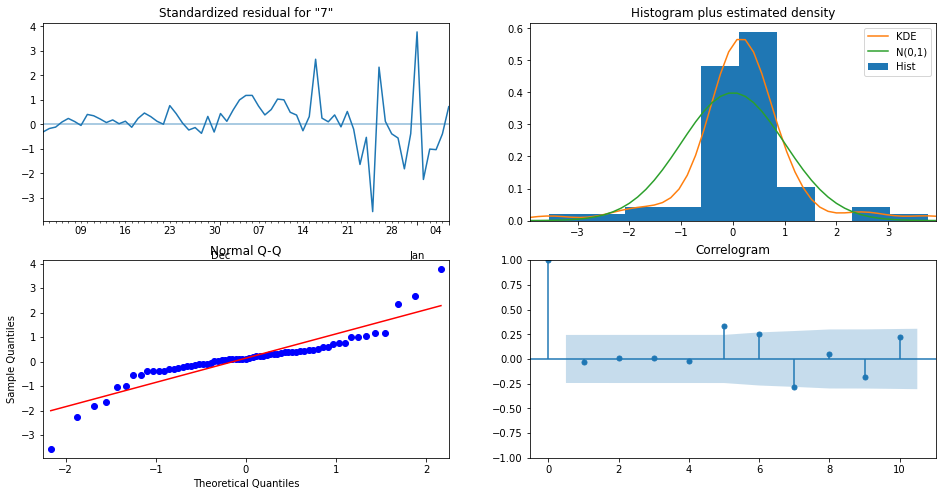

In [42]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

- **standardized residual**: The residual errors seem to fluctuate around a mean of zero and one, although the later third's fluctuation increases to three or four 

- **histogram**: the overall shape follows normal distribution, but heavily centralized 

- **normal Q-Q**: All the dots should fall in line with the red line. There is a greater variation in the sample Q than theoretical Q 

- **correlogram**: the residual errors are not autocorrelated, indicating there is no pattern in the residual errors which are not explained in the model

### model validation using test data

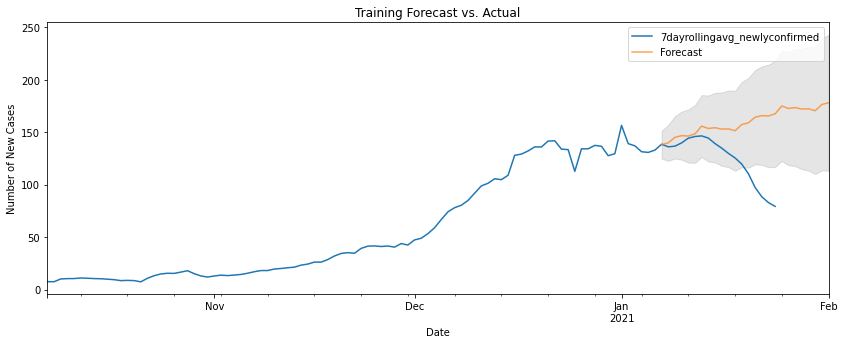

In [44]:
# the train data stops at 2021-1-6, 
# and now we use the test data that starts on 2021-1-7 to see how the model does compared to the actual data



pred = results.get_prediction(start=pd.to_datetime('2021-01-07'),
                              end=pd.to_datetime('2021-2-01'), dynamic=True)
pred_ci = pred.conf_int()

ax = y.plot(label='7dayrollingavg_newlyconfirmed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of New Cases')

plt.title('Training Forecast vs. Actual')
plt.legend()
plt.show()

In [45]:
y_forecasted = pred.predicted_mean
y_truth = (y['2021-1-7':])


diff = y_forecasted - y_truth['7dayrollingavg_newlyconfirmed']

mse = (diff ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse, 2)))

print('RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

MSE of our forecasts is 1716.03
RMSE of our forecasts is 41.43


the model is not able to predict trend changes, so the difference between our forecast and the actual data widens as time goes on

however, unless we incorporate multiple factors that are used by actual forecasting models, such as:
> change in R-values, % infected, % recovered with immunity, county-by-county lockdown recommendations, and other demographics (age, race, ethnicity, income, employment)

forecasting the direction change is very difficult 

### model using all data points

In [55]:

# do "grid search" by automating the iteration
# to find the triplets of parameters with lowest AIC(Akaike Information Criterion) value
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic_d = {}
for param in pdq:
    
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aic_d[param, param_seasonal] = results.aic
        except:
            continue
            
# print out the parameters of the lowest AIC value             
min(aic_d, key=aic_d.get)   
            
  

((1, 1, 1), (0, 1, 1, 12))

- when using all data points up to date, best parameter and seasonal parameter change to (1,1,1)(0,1,1,12)
- now, we will build a model according to that

In [47]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -277.466
Date:                            Thu, 28 Jan 2021   AIC                            562.932
Time:                                    17:34:48   BIC                            572.608
Sample:                                10-07-2020   HQIC                           566.819
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9646      0.080     12.068      0.000       0.808       1.121
ma.L1         -0.8553      0.074    -11.552      0.000      -1.000      -0.710
ma.S.L12      -1.0000   2051.924     -0.000      1.000   -4022.698    4020.698
sigma2        37.7597   7.75e+04      0.000      1.000   -1.52e+05    1.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.30   Jarque-Bera (JB):               157.52
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):              22.40   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

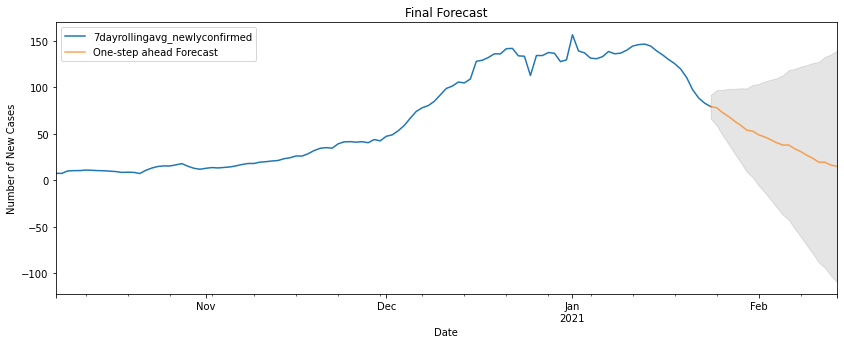

In [48]:

pred = results.get_prediction(start=pd.to_datetime('2021-01-24'),
                              end=pd.to_datetime('2021-2-14'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of New Cases')
plt.title('Final Forecast')
plt.legend()
plt.show()


In [274]:
pred.predicted_mean

2021-01-24    79.224712
2021-01-25    77.983077
2021-01-26    72.711295
2021-01-27    68.516941
2021-01-28    63.526244
2021-01-29    59.138906
2021-01-30    53.972706
2021-01-31    52.928141
2021-02-01    48.920920
2021-02-02    46.660895
2021-02-03    43.584174
2021-02-04    40.374871
2021-02-05    37.959675
2021-02-06    37.960768
2021-02-07    33.887863
2021-02-08    30.849571
2021-02-09    26.974174
2021-02-10    23.662552
2021-02-11    19.534123
2021-02-12    19.490078
2021-02-13    16.447915
2021-02-14    15.118243
Freq: D, Name: predicted_mean, dtype: float64

- the downward trend has been incorporated for modeling when we used all data points
- with a fairly low confidence level, the uncertainty of predictions grow as time goes on

# Modeling for 7 Counties Highest New Cases/100k 
- These 7 counties have 500+ daily newly confirmed cases per 100k (7 day average) with an increasing trend
- we will model these counties for predictions 

In [14]:
hotspot_counties = ['Tehama', 'Riverside', 'Colusa', 'Merced', 'Santa Barbara', 'Inyo', 'Tulare']

In [16]:
features = ['hospitalized_covid_patients', '7dayrollingavg_newdeath', 'all_hospital_beds', 'icu_available_beds']


## Tehama County

In [27]:
Tehama = county_df.loc['Tehama'].tail(110)
Riverside = county_df.loc['Riverside'].tail(110)
Colusa = county_df.loc['Colusa'].tail(110)
Merced = county_df.loc['Merced'].tail(110)
Santa_Barbara = county_df.loc['Santa Barbara'].tail(110)
Inyo = county_df.loc['Inyo'].tail(110)
Tulare = county_df.loc['Tulare'].tail(110)

In [49]:
# build a function to incorporate everything 
warnings.filterwarnings("ignore") 
def sarimax_model (countydf):
    X = countydf[features]
    y = countydf[['7dayrollingavg_newlyconfirmed']]
    X_train = X.iloc[:92]
    X_test = X.iloc[92:]
    y_train = y.iloc[:92]
    y_test = y.iloc[92:]
    
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    aic_d = {}
    for param in pdq:
    
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                results = mod.fit()
                aic_d[param, param_seasonal] = results.aic
            except:
                continue
            
    # print out the parameters of the lowest AIC value             
    min_aic_params = min(aic_d, key=aic_d.get)   
    min_order=min_aic_params[0]
    min_seasonal_order=min_aic_params[1]
    
    mod = sm.tsa.statespace.SARIMAX(y_train,
                                order=min_order,
                                seasonal_order=min_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary())
    
    pred = results.get_prediction(start=pd.to_datetime('2021-01-07'),
                              end=pd.to_datetime('2021-2-01'), dynamic=True)
    pred_ci = pred.conf_int()

    ax = y.plot(label='7dayrollingavg_newlyconfirmed')
    pred.predicted_mean.plot(ax=ax, label='Train Forecast', alpha=.7, figsize=(14, 5))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of New Cases')
    plt.title('Training Forecast vs. Actual')
    plt.legend()
    plt.show()
    
    y_forecasted = pred.predicted_mean
    y_truth = (y['2021-1-7':])


    diff = y_forecasted - y_truth['7dayrollingavg_newlyconfirmed']

    mse = (diff ** 2).mean()
    print('MSE of our forecasts is {}'.format(round(mse, 2)))

    print('RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
    
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    aic_d = {}
    for param in pdq:

        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                aic_d[param, param_seasonal] = results.aic
            except:
                continue

    # print out the parameters of the lowest AIC value             
    min_aic_params = min(aic_d, key=aic_d.get)   
    min_order=min_aic_params[0]
    min_seasonal_order=min_aic_params[1]
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=min_order,
                                seasonal_order=min_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()

    print(results.summary())
    
    pred = results.get_prediction(start=pd.to_datetime('2021-01-24'),
                              end=pd.to_datetime('2021-2-14'), dynamic=True)
    pred_ci = pred.conf_int()
    ax = y['2020':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast of the next 21 days', alpha=.7, figsize=(14, 5))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of New Cases')
    plt.title('Final Forecast')
    plt.legend()
    plt.show()
    print(pred.predicted_mean)
    return 

                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -201.152
Date:                            Thu, 28 Jan 2021   AIC                            408.303
Time:                                    17:35:36   BIC                            414.827
Sample:                                10-07-2020   HQIC                           410.877
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0346      0.176     -0.196      0.844      -0.380       0.311
ma.S.L12      -1.0001    575.499   

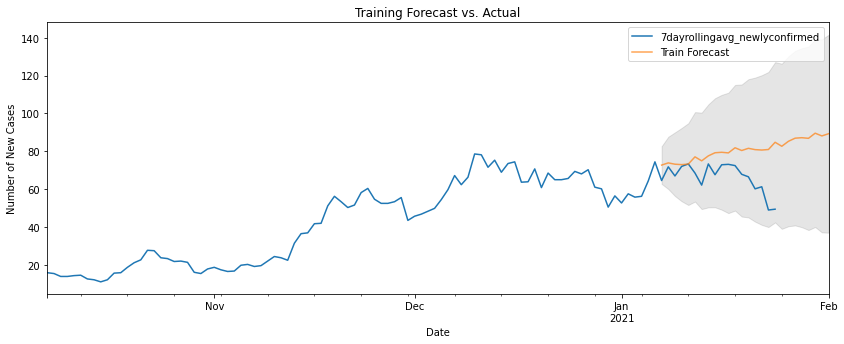

MSE of our forecasts is 229.8
RMSE of our forecasts is 15.16
                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -255.910
Date:                            Thu, 28 Jan 2021   AIC                            519.821
Time:                                    17:35:41   BIC                            529.496
Sample:                                10-07-2020   HQIC                           523.708
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9977      0.051    -19.397      0.00

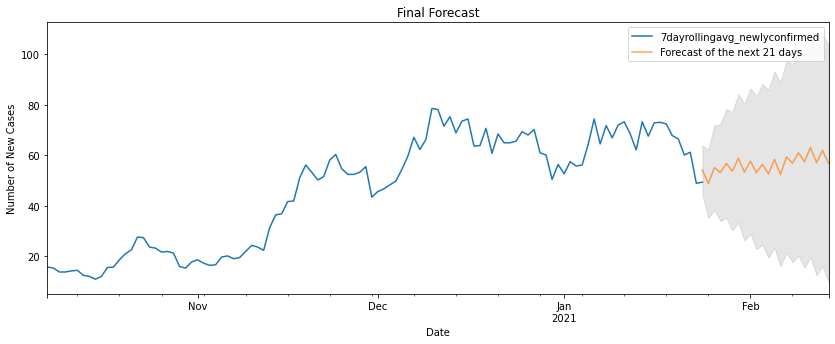

2021-01-24    54.176620
2021-01-25    48.759019
2021-01-26    55.170167
2021-01-27    53.179696
2021-01-28    56.797843
2021-01-29    53.722578
2021-01-30    58.864541
2021-01-31    53.363058
2021-02-01    57.711989
2021-02-02    53.149841
2021-02-03    56.437527
2021-02-04    52.668345
2021-02-05    58.410656
2021-02-06    52.480786
2021-02-07    59.403050
2021-02-08    56.902615
2021-02-09    61.029577
2021-02-10    57.446643
2021-02-11    63.095131
2021-02-12    57.088264
2021-02-13    61.941442
2021-02-14    56.876183
Freq: D, Name: predicted_mean, dtype: float64


In [50]:
sarimax_model(Tehama)

## Riverside County

                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -211.589
Date:                            Thu, 28 Jan 2021   AIC                            431.179
Time:                                    17:35:55   BIC                            439.876
Sample:                                10-07-2020   HQIC                           434.611
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3533      0.268      1.317      0.188      -0.173       0.879
ma.L1          0.1555      0.285   

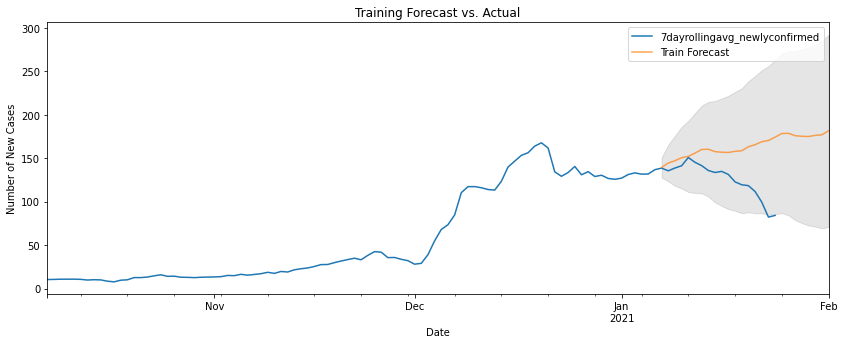

MSE of our forecasts is 1748.4
RMSE of our forecasts is 41.81
                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -272.340
Date:                            Thu, 28 Jan 2021   AIC                            552.679
Time:                                    17:36:02   BIC                            562.355
Sample:                                10-07-2020   HQIC                           556.566
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3847      0.241      1.595      0.1

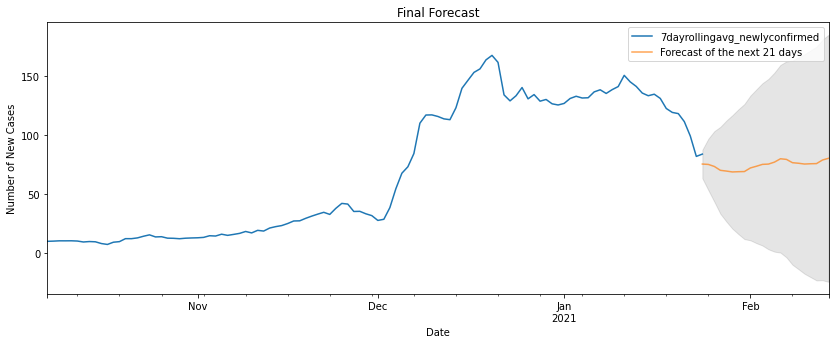

2021-01-24    75.762978
2021-01-25    75.461104
2021-01-26    73.724282
2021-01-27    70.465826
2021-01-28    69.825182
2021-01-29    69.081185
2021-01-30    69.290634
2021-01-31    69.418286
2021-02-01    72.469684
2021-02-02    73.902714
2021-02-03    75.493529
2021-02-04    75.740014
2021-02-05    77.406779
2021-02-06    80.241105
2021-02-07    79.710707
2021-02-08    76.916334
2021-02-09    76.454213
2021-02-10    75.778889
2021-02-11    76.014755
2021-02-12    76.152570
2021-02-13    79.207876
2021-02-14    80.642410
Freq: D, Name: predicted_mean, dtype: float64


In [51]:
sarimax_model(Riverside)

## Colusa County

                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -238.917
Date:                            Thu, 28 Jan 2021   AIC                            483.834
Time:                                    17:36:08   BIC                            490.358
Sample:                                10-07-2020   HQIC                           486.408
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0896      0.169      0.531      0.596      -0.241       0.420
ma.S.L12      -1.0001    273.880   

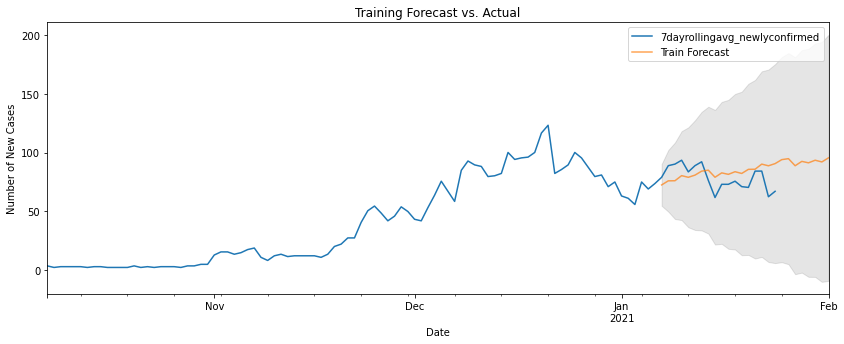

MSE of our forecasts is 166.79
RMSE of our forecasts is 12.91
                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -302.065
Date:                            Thu, 28 Jan 2021   AIC                            610.129
Time:                                    17:36:13   BIC                            617.386
Sample:                                10-07-2020   HQIC                           613.045
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1529      0.139      1.103      0.2

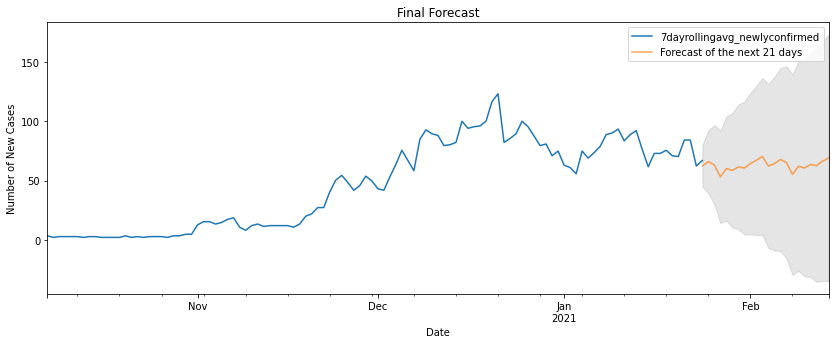

2021-01-24    62.361638
2021-01-25    65.894395
2021-01-26    63.272502
2021-01-27    53.173752
2021-01-28    60.120858
2021-01-29    58.634207
2021-01-30    61.620907
2021-01-31    60.564055
2021-02-01    64.377489
2021-02-02    67.148564
2021-02-03    70.347904
2021-02-04    62.272948
2021-02-05    64.306204
2021-02-06    67.838961
2021-02-07    65.217068
2021-02-08    55.118317
2021-02-09    62.065424
2021-02-10    60.578772
2021-02-11    63.565473
2021-02-12    62.508620
2021-02-13    66.322055
2021-02-14    69.093130
Freq: D, Name: predicted_mean, dtype: float64


In [52]:
sarimax_model(Colusa)

## Merced County

                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -194.556
Date:                            Thu, 28 Jan 2021   AIC                            395.113
Time:                                    17:36:18   BIC                            401.636
Sample:                                10-07-2020   HQIC                           397.687
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1548      0.153      1.014      0.311      -0.144       0.454
ma.S.L12      -1.0001    685.523   

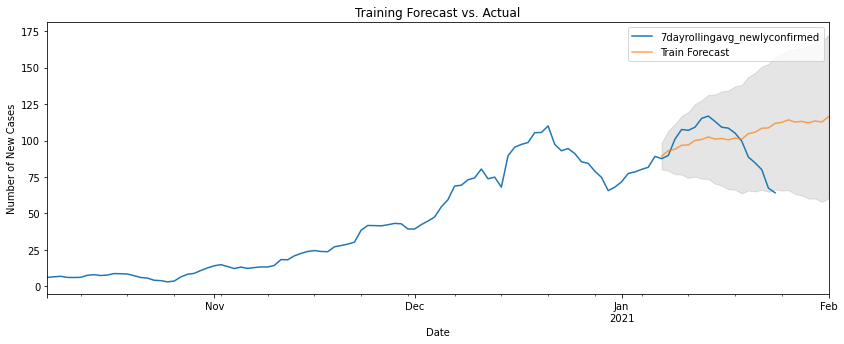

MSE of our forecasts is 363.26
RMSE of our forecasts is 19.06
                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -249.180
Date:                            Thu, 28 Jan 2021   AIC                            506.359
Time:                                    17:36:24   BIC                            516.035
Sample:                                10-07-2020   HQIC                           510.246
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8383      0.152      5.500      0.0

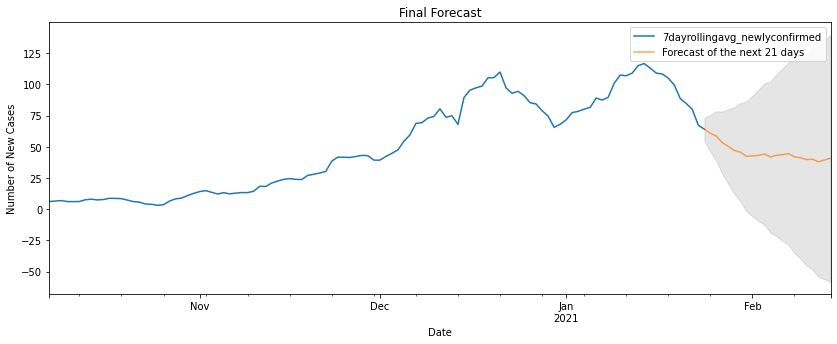

2021-01-24    64.285855
2021-01-25    60.837309
2021-01-26    58.572391
2021-01-27    53.333196
2021-01-28    50.333878
2021-01-29    47.010823
2021-01-30    45.696826
2021-01-31    42.371384
2021-02-01    42.690471
2021-02-02    43.111656
2021-02-03    44.278343
2021-02-04    41.852037
2021-02-05    43.319277
2021-02-06    43.664078
2021-02-07    44.579093
2021-02-08    42.005609
2021-02-09    41.240937
2021-02-10    39.791167
2021-02-11    40.047530
2021-02-12    38.038508
2021-02-13    39.461140
2021-02-14    40.807418
Freq: D, Name: predicted_mean, dtype: float64


In [53]:
sarimax_model(Merced)

## Santa Barbara County

                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -153.615
Date:                            Thu, 28 Jan 2021   AIC                            317.229
Time:                                    17:36:29   BIC                            328.178
Sample:                                10-07-2020   HQIC                           321.555
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0377      0.006    170.017      0.000       1.026       1.050
ma.L1         -0.3058      0.118   

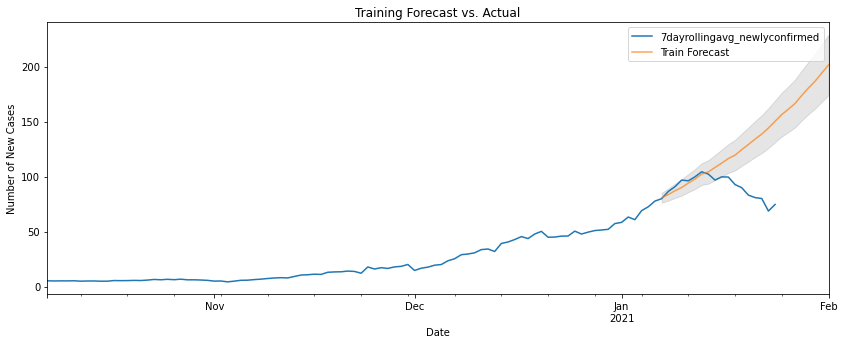

MSE of our forecasts is 1241.03
RMSE of our forecasts is 35.23
                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -213.970
Date:                            Thu, 28 Jan 2021   AIC                            435.939
Time:                                    17:36:34   BIC                            445.614
Sample:                                10-07-2020   HQIC                           439.826
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8926      0.120      7.429      0.

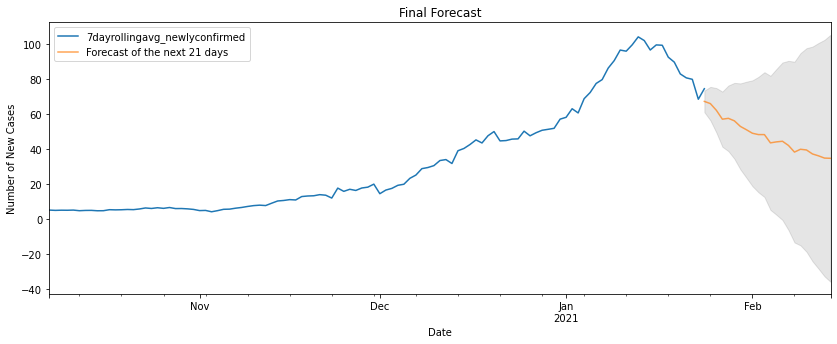

2021-01-24    67.421419
2021-01-25    66.170183
2021-01-26    62.337480
2021-01-27    57.254320
2021-01-28    57.729252
2021-01-29    56.302334
2021-01-30    53.105399
2021-01-31    51.218447
2021-02-01    49.204525
2021-02-02    48.435344
2021-02-03    48.428122
2021-02-04    43.700152
2021-02-05    44.263276
2021-02-06    44.621265
2021-02-07    42.224940
2021-02-08    38.423876
2021-02-09    40.043193
2021-02-10    39.637742
2021-02-11    37.352556
2021-02-12    36.279423
2021-02-13    34.991908
2021-02-14    34.871108
Freq: D, Name: predicted_mean, dtype: float64


In [54]:
sarimax_model(Santa_Barbara)

## Inyo County

                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -226.148
Date:                            Thu, 28 Jan 2021   AIC                            458.297
Time:                                    17:36:38   BIC                            464.820
Sample:                                10-07-2020   HQIC                           460.871
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2127      0.117     -1.818      0.069      -0.442       0.017
ma.S.L12      -1.0000   7843.857   

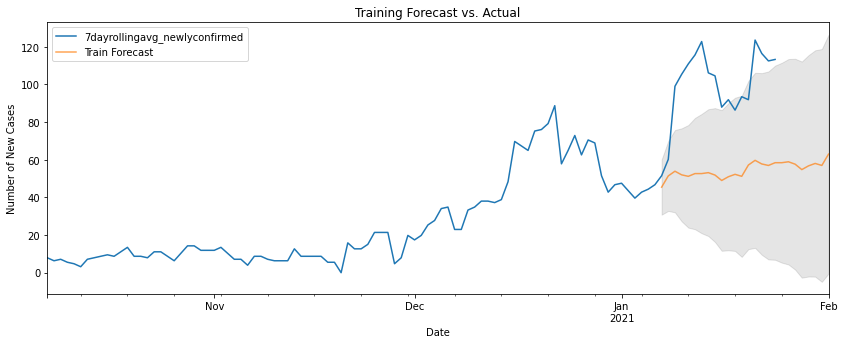

MSE of our forecasts is 2443.37
RMSE of our forecasts is 49.43
                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -299.618
Date:                            Thu, 28 Jan 2021   AIC                            607.235
Time:                                    17:36:44   BIC                            616.911
Sample:                                10-07-2020   HQIC                           611.122
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1234      0.106     -1.166      0.

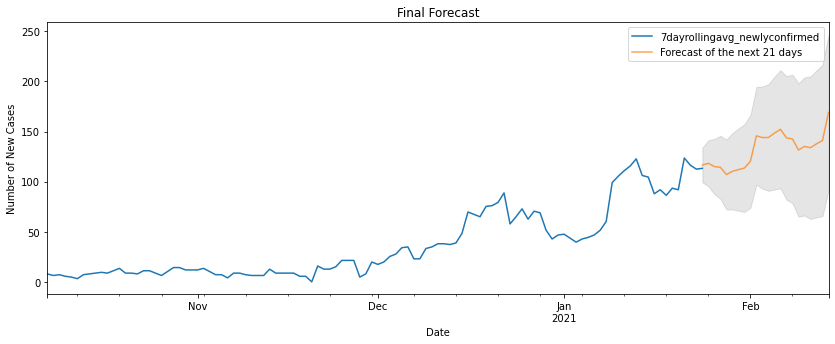

2021-01-24    116.546752
2021-01-25    118.262045
2021-01-26    115.016241
2021-01-27    114.299321
2021-01-28    107.070333
2021-01-29    110.308255
2021-01-30    111.951226
2021-01-31    113.504049
2021-02-01    120.246774
2021-02-02    145.685588
2021-02-03    143.957770
2021-02-04    144.006427
2021-02-05    148.354667
2021-02-06    152.239934
2021-02-07    143.627524
2021-02-08    142.563003
2021-02-09    131.564454
2021-02-10    135.091761
2021-02-11    133.853321
2021-02-12    137.641259
2021-02-13    141.045462
2021-02-14    168.985616
Freq: D, Name: predicted_mean, dtype: float64


In [55]:
sarimax_model(Inyo)

## Tulare County

                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                   92
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -196.813
Date:                            Thu, 28 Jan 2021   AIC                            399.627
Time:                                    17:36:49   BIC                            406.150
Sample:                                10-07-2020   HQIC                           402.201
                                     - 01-06-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4319      0.149      2.893      0.004       0.139       0.724
ma.S.L12      -1.0001    817.956   

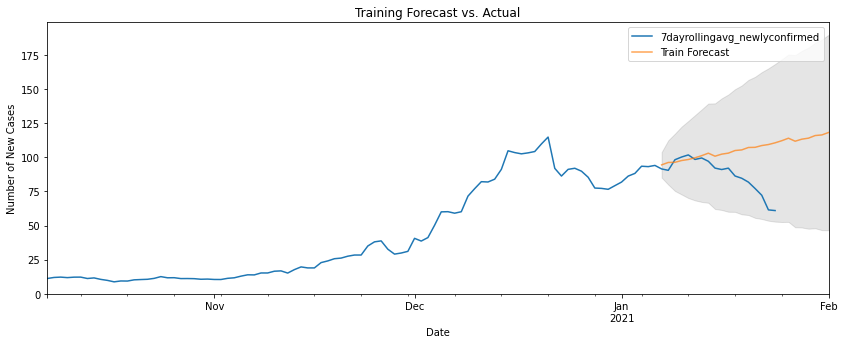

MSE of our forecasts is 491.05
RMSE of our forecasts is 22.16
                                     SARIMAX Results                                      
Dep. Variable:      7dayrollingavg_newlyconfirmed   No. Observations:                  110
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -249.866
Date:                            Thu, 28 Jan 2021   AIC                            505.732
Time:                                    17:36:55   BIC                            512.989
Sample:                                10-07-2020   HQIC                           508.647
                                     - 01-24-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3791      0.142      2.663      0.0

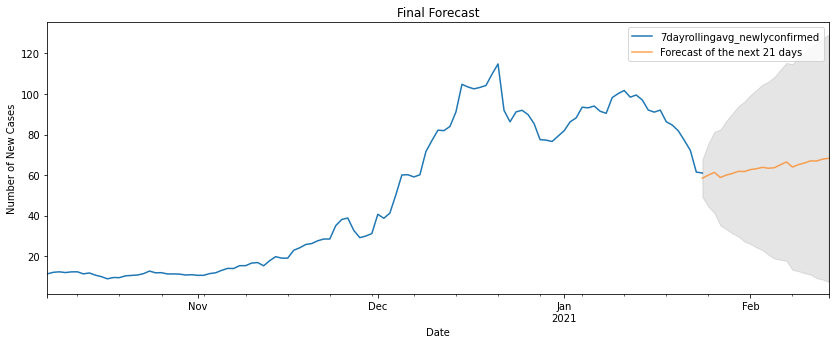

2021-01-24    58.443416
2021-01-25    59.938122
2021-01-26    61.303446
2021-01-27    58.783895
2021-01-28    59.996003
2021-01-29    60.768891
2021-01-30    61.831188
2021-01-31    61.718829
2021-02-01    62.668767
2021-02-02    63.097771
2021-02-03    63.782139
2021-02-04    63.342932
2021-02-05    63.599491
2021-02-06    65.094196
2021-02-07    66.459520
2021-02-08    63.939969
2021-02-09    65.152077
2021-02-10    65.924966
2021-02-11    66.987262
2021-02-12    66.874903
2021-02-13    67.824841
2021-02-14    68.253845
Freq: D, Name: predicted_mean, dtype: float64


In [56]:
sarimax_model(Tulare)